This script gives an overview of the functions and methods used for the transdimensional inversion of tomographic DFN observations

In [11]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

# Forward modeling modules
import Field_models.functions.initialize as finit
import Field_models.functions.geometry as fgeom
import Field_models.functions.FieldForwardModel as FFM
#import Field_models.functions.AdvancedFieldForwardModelTTT as AFFMTTT
#import Field_models.functions.HydraulicTomography as HT

# Inversion modules
import rjMCMC_DFN_CTT.functions.geometry as geom
import rjMCMC_DFN_CTT.functions.initialize as init
import rjMCMC_DFN_CTT.functions.inversion as inv
import rjMCMC_DFN_CTT.functions.DFN_transportF as FM
import rjMCMC_DFN_CTT.functions.AdvancedForwardModel as AFM

## Data and forward model

The "field" DFN models are stored in a numpy format.
The field DFN model has the following columns:

    X_center Y_center Length Angle

In [29]:
DFN_field = np.load('Field_models/models/DFN4.npy')
print('X_center \tY_center \tLength \tAngle')
print(DFN_field)

X_center 	Y_center 	Length 	Angle
[[ 3.          8.5         6.70820393 -0.46364761]
 [ 2.5        14.          5.38516481 -0.38050638]
 [ 4.         19.5         9.43398113 -0.55859932]
 [29.5         6.          5.38516481 -0.38050638]
 [30.         17.5         6.40312424 -0.89605538]
 [27.         26.         10.19803903 -0.19739556]
 [ 5.         17.5         9.21954446  1.35212738]
 [ 5.5         8.          4.12310563  1.32581766]
 [13.5        18.         18.02775638 -0.33929261]
 [21.5        21.5        13.34166406  1.34399748]
 [28.         14.         18.11077028  1.46013911]
 [16.         12.5        15.13274595  1.43824479]
 [10.5         8.5        11.40175425 -0.26625205]
 [21.5        12.5        13.92838828 -0.36717383]]


The plot_DFN_field function is used to plot the DFN data. It only uses matplotlib. I use a separate version for field models (where the fracture angles are in the DFN) and for the inversion (where instead of angles, only the fracture set).

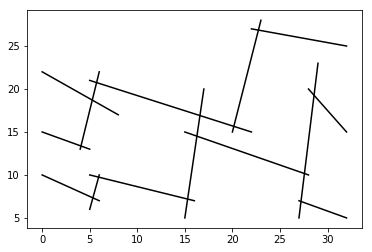

In [14]:
fgeom.plot_DFN_field(DFN_field)

To run any forward model, the fracture sets have to be defined.
The forward model uses 2 fracture sets which could have different physical parameters - in this case different fracture apertures. They can be defined according to the fracture angles:

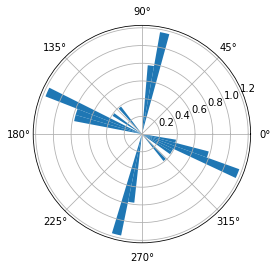

In [35]:
plt.subplot(1,1,1,projection='polar')
x,y, _ = plt.hist(np.hstack([DFN_field[:,3],DFN_field[:,3]+np.pi]),60,density='True')
y = y[:len(y)-1]
bins = y[2]-y[1]

The fracture sets dipping down and up are separated.

In [20]:
# Assign fracture sets
sets = np.ones(np.shape(DFN_field)[0])
for i in range(0,np.shape(DFN_field)[0]):
    if DFN_field[i,3]<0:  #limit angle of sets
        sets[i] = 2
DFN_field = np.column_stack([DFN_field,sets])
print(DFN_field)

[[ 3.          8.5         6.70820393 -0.46364761  2.        ]
 [ 2.5        14.          5.38516481 -0.38050638  2.        ]
 [ 4.         19.5         9.43398113 -0.55859932  2.        ]
 [29.5         6.          5.38516481 -0.38050638  2.        ]
 [30.         17.5         6.40312424 -0.89605538  2.        ]
 [27.         26.         10.19803903 -0.19739556  2.        ]
 [ 5.         17.5         9.21954446  1.35212738  1.        ]
 [ 5.5         8.          4.12310563  1.32581766  1.        ]
 [13.5        18.         18.02775638 -0.33929261  2.        ]
 [21.5        21.5        13.34166406  1.34399748  1.        ]
 [28.         14.         18.11077028  1.46013911  1.        ]
 [16.         12.5        15.13274595  1.43824479  1.        ]
 [10.5         8.5        11.40175425 -0.26625205  2.        ]
 [21.5        12.5        13.92838828 -0.36717383  2.        ]]


The modelings are initialized as follows. The initialization function contains the statistical information on the DFN.

To run the forward model the source and receiver locations have to be defined too. In the SR_coord matrix type 1 is a source and type -1 is a receiver. (Note that most forward models are designed to work with 3/3 only, and are not tested with other SR numbers.)

In [37]:
[dim,dx,sx,theta,pdo,frac_l] = finit.init()
SR_coord = np.array(((1,0,10),(1,0,15),(1,0,22),(-1,32,5),(-1,32,15),(-1,32,25)))
print('type X Y')
print(SR_coord)

type X Y
[[ 1  0 10]
 [ 1  0 15]
 [ 1  0 22]
 [-1 32  5]
 [-1 32 15]
 [-1 32 25]]


In [24]:
#C_BT = FFM.DFN_transport(DFN_field,SR_coord,theta) # - this is slow
C_BT = np.load('Field_models/models/CTT4.npy')

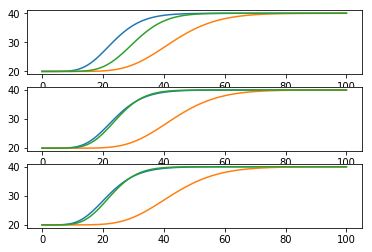

In [25]:
plt.subplot(3,1,1)
plt.plot(C_BT[0])
plt.subplot(3,1,2)
plt.plot(C_BT[1])
plt.subplot(3,1,3)
plt.plot(C_BT[2])

# Inversion scripts:

For the inversion the same initialization is used as above.

In [38]:
# Initialization
[dim,dx,sx,theta,pdo,frac_l] = init.init()
SR_coord = np.array(((1,0,10),(1,0,15),(1,0,22),(-1,32,5),(-1,32,15),(-1,32,25)))
fracture_intensity = 0.5
fmax = dim[0]*dim[1]*fracture_intensity #Overall fracture length for the domain

fracture_intensity is the parameter that controls the initial number of fractures. 
It is calculated as: 

$P_{21} = \frac{\sum{fracturelength}}{area}$

This information is enough to generate random DFN realizations with the same statistics as the investigated model

In [39]:
DFN0 = inv.RandomDFNGenerator(SR_coord,dim,dx,theta,frac_l,fracture_intensity)

This algorithm creates a DFN model, where all sources and receivers are connected, and has the desired statistics.
The method works as follows:
    1. Connector fractures are added to the SR points
    2. A very dense network is created by adding new fractures to the existing ones.
    3. Fractures are randomly removed to reach a homogeneous desired fracture density while maintaining the connection
    
Note that the function is not working 100% and it should be further optimized

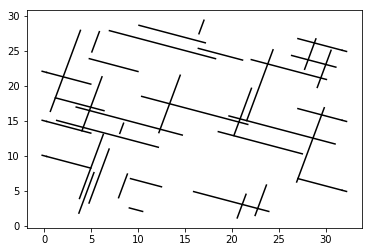

In [40]:
geom.plot_DFN(DFN0,theta)

We can calculate the fracure density in the subregions:

In [42]:
geom.CalculateP21(DFN0,dim,theta,dx)

array([[0.48333333, 0.96666667, 0.98333333, 0.43333333],
       [0.26666667, 0.45      , 0.51666667, 0.51666667],
       [0.55      , 0.4       , 0.63333333, 0.46666667],
       [0.23333333, 0.63333333, 0.51666667, 0.68333333]])

## DFN manipulation methods

### Fracture addition:
To add a new fracture to the model, first the existing network has to be discretized.
We define insertion points where new fractures can be inserted, For this a pre-defined discretization length (dx) is used.

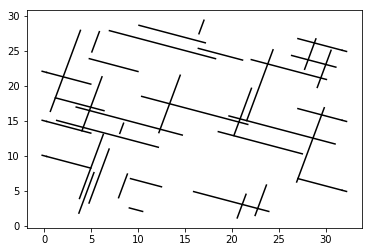

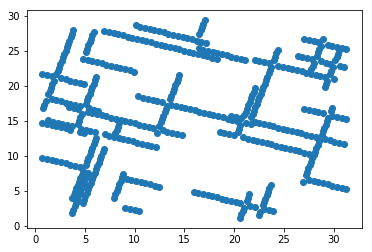

In [44]:
insertion_points = geom.FindInsertionPoints(DFN0,dx,dim,theta)

geom.plot_DFN(DFN0,theta)
plt.scatter(insertion_points[:,0],insertion_points[:,1])

In [46]:
print('X \tY \tSet \tspace_above \tspace_below \fracture_number')
print(insertion_points)

X 	Y 	Set 	space_above 	space_below racture_number
[[ 0.707066    9.74988468  2.         31.42960354  1.54816378  6.        ]
 [ 1.17844333  9.58314113  2.         42.3780508   5.07249572  6.        ]
 [ 1.64982066  9.41639759  2.         42.72415039  8.59682766  6.        ]
 ...
 [23.41977752  4.86059395  1.         18.20245031 48.62299464 43.        ]
 [23.55352694  5.34237305  1.         17.91870859 48.90673636 43.        ]
 [23.68727635  5.82415214  1.         17.63496687 49.19047807 43.        ]]


The most complicated part is the space above/below. This tells us how far is the closest fracture from the same set at the same x/y locateion in the coord system of the DFN. These values are used to avoid any overlaping fractures. We use this value when we draw the length for the new fracture as a limit.

The length of the new fracture is drawn of the discretized version of the following distribution.

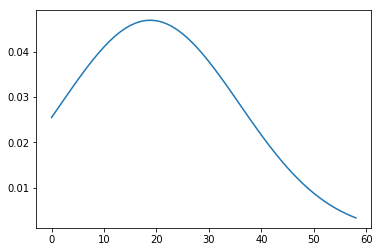

In [49]:
plt.plot(frac_l[1,:])

For this drawing we use the cumulative version of this PDF.

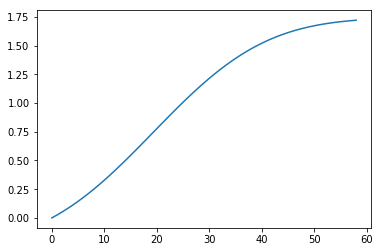

In [50]:
plt.plot(frac_l[2,:])

by drawing random numbers from [0,1] fracture lengths can be drawn according to the above distribution using this CDF. This is implemented in function:



In [53]:
 A = np.zeros([1,np.shape(frac_l)[1]])
while(np.max(A)<=0):
    r2 = np.random.rand(1)
    A = frac_l[2,:]-r2
l_new = frac_l[0,np.where(A == min(A[A>0]))]
print(l_new)

[[6.]]


### Fracture deletion

For fracture deletion, first the deleteable fractures are identified

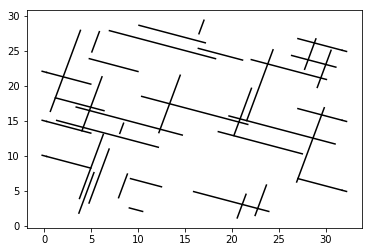

[[17.]
 [19.]
 [20.]
 [21.]
 [24.]
 [27.]
 [28.]
 [30.]
 [31.]
 [32.]
 [35.]
 [37.]
 [38.]
 [39.]
 [40.]
 [41.]
 [42.]
 [43.]]


In [55]:
delf = geom.GetDeleteableFracturesP(DFN0,SR_coord,dim,dx,theta,2)

geom.plot_DFN(DFN0,theta)
print(delf)

Then we just randomly delete a fracture from the list and we are done.

### Move fracture

This is basically just the combination of the other two (there are more complex solutions where the movement is constrained, but they do not perform that well, and not really neccessary).

# DFN inversion

rjmCMC uses an iterative process to solve the inverse problem. Each iteration has two phases an update and an evaluation phase. The used updates are presented above, here I will show the steps of the evaluation.

In [56]:
DFN_old = DFN0

Misfit calculation

In [57]:
Xio = np.load('Field_models/models/CTT4.npy')
Xi = AFM.Forward_model(DFN_old,SR_coord,theta)
RMS = np.sqrt(np.sum(np.sum((Xi-Xio)**2)))

RMS = 469.2150234127403


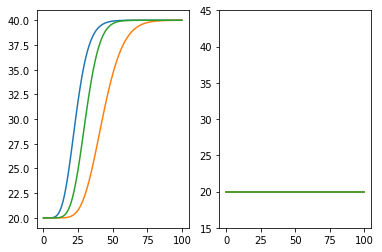

In [82]:
point = 0
plt.subplot(1,2,1)
plt.plot(Xio[point])
plt.subplot(1,2,2)
plt.plot(Xi[point])
plt.ylim(15,45)

print('RMS = ' + str(RMS))

The misfit can be calculated as the sum of the differences over time, but also temporal moments of the breaktrough curves can be used (travel-time).

The Likelihood can be calculated from the RMS

In [64]:
sigma = 10

L = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-0.5*RMS**2/(sigma**2))
print(L)

0.0


The value of sigma controls the convergence rate. Choosing a smaller value increase the convergence but also the risk of getting trapped in an incorrect solution.

Let's go through an evaluation step in the example of a fracture addition!  
First, we update the model as follows:

In [71]:
update_id = 1
insertion_points = geom.FindInsertionPoints(DFN_old,dx,dim,theta)
[DFN_new,flag,selected_ins_id] = geom.AddFracture(DFN_old,insertion_points,frac_l,dx,theta)
update_info_variable = [selected_ins_id,insertion_points]
print(flag)

1


In [68]:
Xi_old = np.copy(Xi)
RMS_old = np.copy(RMS)
Xi_new = AFM.Forward_model(DFN_new,SR_coord,theta)
RMS_new = np.sqrt(np.sum(np.sum((Xi_new-Xio)**2)))
print(RMS_new)

468.64984856633873


The updated model is evaluated using the Metropolis-Hastings-Green acceptance criteria:

$\alpha = min\left(1,\frac{P_2}{P_1} \frac{L_2}{L_1} \frac{Q_{2\rightarrow1}}{Q_{1\rightarrow2}} |J|\right)$

which is created by the product of the prior ratio, the likelihood ratio and the proposal ratio. The last term of the expression is called the Jacobian, but if the model space is fully discretized its value is always one. In this case the prior ratio is also one, as only flat priors were used.

The likelihood ratio is calculated directly from the RMS errors:  
(We cannot calculate it from the L-s directly as they are usually too small)

In [69]:
L_ratio = np.exp((RMS_old-RMS_new)/(2*sigma**2)) 
print('L_ratio = ' + str(L_ratio))

L_ratio = 1.002829870778288


The prior ratio is always one as we only deal with non-informative priors. The value of J is also 1, because the model space fully discretized.

The calculation of the proposal ratio is implemented as the following function:

In [75]:
P1 = 0.3
P2 = 0.3
P3 = 0.4
[P_forward,P_backward] = inv.CalculateUpdateProbability(update_id,SR_coord,DFN_new,DFN_old,dx,dim,frac_l,theta,P1,P2,P3,update_info_variable)
print(P_backward, P_forward)
print(P_backward/P_forward)

0.015789473684210527 [6.62783644e-07]
[23822.96821649]


The role of the proposal ratio is to maintain the stability of the MCMC algorithm.

In [79]:
alpha = L_ratio*(P_backward/P_forward)
print(alpha)

[23890.3841381]


In [81]:
beta = np.random.rand(1)
print(beta)
print(alpha>beta)

[0.09755061]
[ True]
